# Random Kitchen Sinks - full experimental

## Introduction

In this notebook, we try to simulate all the physical limitation of our algorithm. As done in the experimental notebook, we simulate threshold detection, noise and sampling. Here, we add source imperfections and losses. It is established that we can transfer those phenomenon to the sources. In particular, our source may send zero, one or two parameters.

The parameters of the sources are present in the code and can be modified by the user.

## Threshold detection

We start by implementing threshold detection. As previously, we convert the number resolving detection basis into the threshold detection basis.

In [1]:
def threshold_convert(state):
    res=[]
    state_str=str(state)
    state_str=state_str[1:len(state_str)-1]
    state_list=list(map(int, state_str.split(",")))
    for i in range(len(state_list)):
        if state_list[i] > 0:
            res.append(1)
        else:
            res.append(0)
    return res

Here, the detectors may detect nothing (i.e. $|0,0,0>$ is a possible outcome), therefore we have $2^m$ possible outcomes.

In [2]:
def order(threshold_state):
    str_car="0b"
    for car in threshold_state:
        str_car = str_car + str(car)
    return int(str_car, 2)

## Sampling

Sampling is simulated numerically by taking the threshold probabilities and drawing $\text{N_DRAW}$ values according to the aforementioned probability law. The threshold probability law is computed using the SLOS backend.

In [3]:
def noisy_prob():
    """
    Computes the noisy threshold detection probability.
    
    Input:
        s1: backend
        input_state
    """
    _, output_distribution=QPU.run(simulator_backend)
    probs=np.zeros((2**m,))
    for state, prob in output_distribution.items():
        probs[order(threshold_convert(state))]+=prob
    if N_DRAW==float("inf"):  # no sampling case
        return probs
    sample=np.random.choice(np.arange(len(probs)), size=(N_DRAW,), p=probs)
    res=[]
    for i in range(len(probs)):
        res.append(np.count_nonzero(sample==i))
    return np.array(res) / np.sum(res)

## Parameters noise

Parameters noise takes into account the discretization of the controlling tension and other sources of noise which we call "thermic noise".

In [4]:
N_DRAW=1000 # number of draws
step = 6.5 * 1e-3 # increment of phase control
thermic_noise=1e-3 # thermic noise (includes other sources of noise)

In [5]:
def noisy_angle(angle):
    """
    Computes the angle observed by the phase shifter due to the discretization of the input voltage.
    """
    if step==0:
        return angle
    return angle - np.remainder(angle, step)

## Use of a theoritical $\lambda$ for computing $x \mapsto \sqrt{2} \cos x$

It can be shown that the unitary matrix of our circuit is:

\begin{equation*}
\begin{pmatrix}
\frac{e^{ix} - 1}{2} & \frac{i(e^{ix} + 1)}{2} \\
\frac{i(e^{ix} + 1)}{2} & -\frac{e^{ix} - 1}{2} 
\end{pmatrix}
\end{equation*}

If we send a single photon, we get the following probabilites:

\begin{equation*}
|<1-m, m|\mathcal{U}(x)|1, 0>|^2 = \cos^{2m}\left(\frac{x}{2}\right) \sin^{2(1-m)}\left(\frac{x}{2}\right)
\end{equation*}

Hence:

\begin{equation*}
\sqrt{2} \cos x = \sqrt{2} \left(|<0, 1|\mathcal{U}(x)|1, 0>|^2 - |<1, 0|\mathcal{U}(x)|1, 0>|^2 \right)
\end{equation*}

In the remaining of our notebook, we use this theoritical value of $\lambda$.

### Importation of modules

In [6]:
import numpy as np
import perceval as pcvl
import perceval.lib.symb as symb
from math import comb
import sklearn.datasets as skdt
import time
from scipy.optimize import basinhopping
from copy import deepcopy
import matplotlib.pyplot as plt
import pybobyqa
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit.utils import algorithm_globals
from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

### Definition of the constants, the circuit and the simulator

In [7]:
m = 2 # number of modes
n = 1 # number of photons
input_state = pcvl.BasicState([n, 0]) # |n, 0>
x_ri = pcvl.P("x_ri") # parameter x_r,i = gamma * (w_r . x_i + b_r)
k = 1

In [8]:
c = symb.BS() // (0, symb.PS(x_ri)) // symb.BS() # cicruit definition
pcvl.pdisplay(c)

In [9]:
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
source=pcvl.Source(brightness=0.6, purity=.99)
QPU=pcvl.Processor({0:source}, c)
pcvl.pdisplay(QPU.source_distribution)

state,probability
"|1,0>",0.594
"|0,0>",2/5
"|2,0>",0.006


### Definition of the approximate quantum function

In [10]:
def quantum_value(xRI, lambda_random):
    """
    Wrapper that define the quantum circuit computation. It computes the noisy parameters of the circuit and the approximated
    value of the probabilities
    """
    x_ri.set_value(np.random.normal(loc=noisy_angle(xRI) % (2 * np.pi), scale=thermic_noise)) # set the new phase of the phase shifter
    return np.sum(np.multiply(noisy_prob(), lambda_random)) # observable computation

### Definition of  constants

The value of $R$ is very important. It defines the expressivity of the circuit. On the one hand, a too small value leads to the under-fitting. On th other hand, a too large value leads to over-fitting. Moreover, the approximation of replacing the expectancy by the realization require a value high enough. For this reason, *the wrapper at the end of the notebook redefines its value according to the following (empircally found) rules*:

1. For linear datasets: $R = 3$
2. For circular datasets: $R = 20$
3. For lunar datasets: $R = 30$

As the reader may have noticed, some numbers are different from those of the ideal case. Indeed, it seems that noise and sampling (threshold detection plays no role in it) induce a loss of expressivity, which needs to be compensated by higher values of $R$.

In [11]:
h = .03    # step size in the mesh
gamma = 0.1 # scale parameter
R = 20   # this is the key value

#### Value of $\lambda$

This is the theoretical of $\lambda$ that was introduced earlier.

In [12]:
lambda_random =np.array([0, np.sqrt(2), -np.sqrt(2), 0])  # post-selection against double-detection

##### Comparaison between the quantum kernel and the real functions

One can remark that our function approximates correctly the function up to a scale. Our explanation is that some probability is lost in the zero and two photon cases.

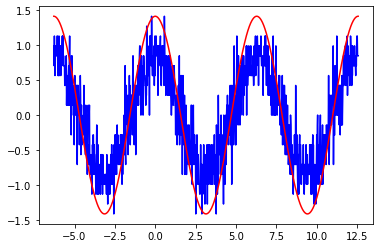

In [13]:
N_DRAW=10
X = np.linspace(-2 * np.pi, 4 * np.pi, num = 1000)
plt.plot(X, [quantum_value(x, lambda_random) for x in X], 'b')
plt.plot(X, np.sqrt(2) * np.cos(X), 'r')
plt.show()

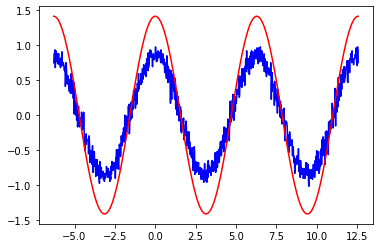

In [14]:
N_DRAW=100
X = np.linspace(-2 * np.pi, 4 * np.pi, num = 1000)
plt.plot(X, [quantum_value(x, lambda_random) for x in X], 'b')
plt.plot(X, np.sqrt(2) * np.cos(X), 'r')
plt.show()

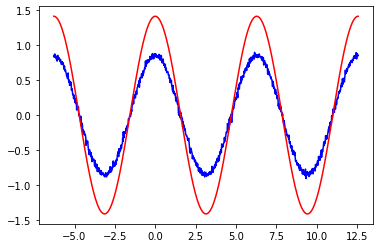

In [15]:
N_DRAW=1000
X = np.linspace(-2 * np.pi, 4 * np.pi, num = 1000)
plt.plot(X, [quantum_value(x, lambda_random) for x in X], 'b')
plt.plot(X, np.sqrt(2) * np.cos(X), 'r')
plt.show()

### Data generation

The input points are normalized in order to make the graphical representation easier.

In [16]:
def normalizeX(z):
    """
    Sets the values between -1 and 1 linearly
    """
    zmax = np.max(z)
    zmin = np.min(z)
    return 2 * (z - zmin) / (zmax - zmin) - 1

def normalizey(z):
    """
    Values between -1 and 1 by replacing 0 values by -1
    """
    for i in range(len(z)):
        if z[i] == 0:
            z[i] = -1
    return z

def generate_data(type, N, noise_param):
    """
    Generates random datasets of different types
    type == 0: linear dataset
    type == 1: circular dataset
    type == 2: moon dataset
    
    >> Default noise values:
        - linear dataset: 1.5
        - circular dataset: 0.03
        - moon dataset: 0.1
    """
    if type == 0 and noise_param is None: # linear
        X, y = skdt.make_blobs(n_samples=N, centers=2, n_features=2, cluster_std = 1.5)
    elif type == 0: # linear
        X, y = skdt.make_blobs(n_samples=N, centers=2, n_features=2, cluster_std = noise_param)
    elif type == 1 and noise_param is None: # circlar
        X, y = skdt.make_circles(n_samples=N, noise=0.03)
    elif type == 1: # circlar
        X, y = skdt.make_circles(n_samples=N, noise= noise_param)
    elif type == 2 and noise_param is None: # moon
        X, y = skdt.make_moons(n_samples=N, noise=0.1)
    elif type == 2: # moon
        X, y = skdt.make_moons(n_samples=N, noise=noise_param)
    else:
        raise(ValueError("Invalid value of type. Enter help(generate_data) for more information"))
    # data normalization
    X = normalizeX(X)
    y = normalizey(y)
    return X, y

### Definition of the random Fourier features

Here we define the random Fourier features. We propose several Fourier transform distributions from **numpy.random**.

In [17]:
def random_parameter(name_law, d = 2):
    """
    sets a new value to the x_{r,i} parameter
    
    Symmetry of the Fourier transform is not required since the real part is already taken 
    (we use cosines instead of complex exponentials).
    
    >> Available names:
    
        - exponential: np.random.exponential(size = d)
        - chisquare: np.random.chisquare(1, size = d)
        - beta: np.random.beta(2, 2, size = d)
        - lognormal: np.random.lognormal(size = d)
        - logistic: np.random.logistic(size = d)
        - laplace: np.random.laplace(size = d)
        - gamma: np.random.gamma(2, size = d)
        - triangular: np.random.triangular(-1, 1, size = d)
        - cauchy: np.random.standard_cauchy(size = d)
        - pareto: np.random.pareto(1, size = d)
        - normal: np.random.normal(size = d)
        - vonmises: np.random.vonmises(0, 4, size = d)
        - uniform: np.random.uniform(low=-1, high=1, size = d)
        - wald: np.random.wald(3, 2, size = d)
        - weibull: np.random.weibull(5, size = d)
        - student: np.random.standard_t(1, size = d)
        - f (Fisher-Snedecor): np.random.f(100, 100, size = d)
    """
    
    # omega definition
    if name_law == "exponential":
        w_r = np.random.exponential(size = d) 
    elif name_law == "chisquare":
        w_r = np.random.chisquare(1, size = d)
    elif name_law == "beta":
        w_r = np.random.beta(2, 2, size = d)
    elif name_law == "lognormal":
        w_r = np.random.lognormal(size = d)
    elif name_law == "logistic":
        w_r = np.random.logistic(size = d)
    elif name_law == "laplace":
        w_r = np.random.laplace(size = d)
    elif name_law == "gamma":
        w_r = np.random.gamma(2, size = d)
    elif name_law == "triangular":
        w_r = np.random.triangular(-1, 0,  1, size = d)
    elif name_law == "cauchy":
        w_r = np.random.standard_cauchy(size = d)
    elif name_law == "pareto":
        w_r = np.random.pareto(1, size = d)
    elif name_law == "normal":
        w_r = np.random.normal(size = d)
    elif name_law == "vonmises":
        w_r = np.random.vonmises(0, 4, size = d)
    elif name_law == "uniform":
        w_r = np.random.uniform(low=-1, high=1, size = d)
    elif name_law == "wald":
        w_r = np.random.wald(3, 2, size = d)
    elif name_law == "weibull":
        w_r = np.random.weibull(5, size = d)
    elif name_law == "student":
        w_r = np.random.standard_t(1, size = d)
    elif name_law == "f":
        w_r = np.random.f(100, 100, size = d)
    else:
        raise("Value Error: Law name undefined")
        
    b_r = np.random.uniform(0, 2 * np.pi)
    return w_r, b_r

### Definition of the linear operations on the Fourier features

Even though <a href="https://arxiv.org/abs/2107.05224v1">Gan et al </a> states that $c_ {opt}$ is computed through the formula:

\begin{equation*}
    c_{opt} \ = (z(X)^T z(X) + \alpha \ I_R)^{-1}\ z(X)^T \ y,
\end{equation*}

it is well-known that a linear system resolution is faster than a matrix inversion and matricial product. We therefore encoded this formula through the resolution of the linear system:

\begin{equation*}
    (z(X)^T z(X) + \alpha \ I_R) \ c_{opt} \ = \ z(X)^T \ y
\end{equation*}

In [18]:
def q_z(X):
    """
    Defines the vector containing the different Fourier terms with the correct normalization
    """
    res = []
    for r in range(R):
        res.append(quantum_value(gamma * (np.dot(w[r], X) + b[r]), lambda_random))  # x_r,i = gamma * (w_r . x_i + b_r)
    return np.array(res) / np.sqrt(R) # normalization

def qZ(X):
    """
    Defines the matrix z(X) from the Fourier feature vectors
    """
    res = []
    print(">>> Resolve linear system")
    for i in tqdm(range(len(X))):
        res.append(q_z(X[i])) # this way of defining the matrix computes the transposition directly
    return np.array(res) / np.sqrt(R) # normalization

def c_opt(mat_Z, y):
    """
    Defines the resolution of the linear system.
    
    Inputs: z(X) matrix and the training label vector y
    """
    mat_Z_t = np.transpose(mat_Z)
    return np.linalg.solve(mat_Z_t @ mat_Z, mat_Z_t @ y)

def q_classifier(c_opt_val, x):
    """
    Defines the classifier that is linear in the Fourier feature space.
    We still have to take the sign in order to get the actual classification.
    """
    return np.dot(c_opt_val, q_z(x)) # inner product between c_opt and z(x)

### Score

The score uses the usual formula. However, it is computed by using a yet unused set (what one may call a test set).

In [19]:
def q_score(X, y, c_opt_val): # quantum score
    """
    Computes the score over the given set X and labels y using the given c_opt vector.
    """
    cpt = 0
    print(">>> Scoring")
    for i in tqdm(range(len(X))):
        if np.sign(q_classifier(c_opt_val, X[i])) == y[i]: cpt += 1
    return cpt / len(X)

### Graphical representation

The plot shows another unused set with the classification of the square $[-1.1, 1.1] \times [-1.1, 1.1]$.

In [20]:
def plot_q_classification(X, y, c_opt_val, ret):
    """
    Defines the graphical representation which contains some points and their corresponding labels,
    the background is the classification of the square [-1.1, 1.1] x [-1.1, 1.1] and the score (given
    in the input) written in the title.
    """
    plt.figure(figsize=(8,8))# Generate figure

    # create a mesh for the background
    xx = np.arange(-1.1, 1.1, h)
    yy = np.arange(-1.1, 1.1, h)
    zs = np.zeros((len(xx), len(yy)))
    print(">>> Plotting")
    for i in tqdm(range(len(xx))):
        for j in range(len(yy)):
            zs[i, j] = np.sign(q_classifier(c_opt_val, np.array([xx[i], yy[j]])))
    cs = plt.contourf(xx, yy, zs, cmap=plt.cm.coolwarm)
    plt.colorbar(cs)

    # Plot scatter points
    plt.scatter(
        X[y == -1, 1],
        X[y == -1, 0],
        s=4,
        label='-1',
        alpha=1, c = ["#0cf9f1"]
    )
    plt.scatter(
        X[y == 1, 1],
        X[y == 1, 0],
        s=4,
        label='1',
        alpha=1,
        c = ["#790909"]
    )

    plt.xlabel('x', fontsize=18)
    plt.ylabel('y', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    lgnd = plt.legend(fontsize=5)

    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    for it in range(2):
        lgnd.legendHandles[it]._sizes = [40]
    plt.title("score = " + str(ret))  # write the score in the title
    plt.show()

### Wrapper

This wrapper calls the functions defined before. It starts by defining the Fourier spectrum (using eventually the user input), then redefines $R$, which turned out to be a *very important* parameter in the classification. This redefinition is done accordingly to the type of datast. Afterwards, it generates the data set (using the noise parameter if it is given) and divides it into three subsets (training, test and grapical representation). Then, it computes the vector $z(X)$ and solves the linear system. Finally, it computes the score and shows the graphical representation.

In [21]:
def q_fit(type, N=1000, noise_param=None, name_law=None):
    """
    Wrapper that uses a prepared quantum kernel in order to call all the classification steps:
    1. Fourier spectrum definition, R redefinition and data generation using noise_param if not noise_param is None
    2. Definition of c_opt by resolving the linear system
    3. Score computation
    4. Graphical representation
    
    >> Default noise values:
        - linear dataset: 2
        - circular dataset: 0.03
        - lunar dataset: 0.1
        
    >> Available names (by default normal):
    
        - exponential: np.random.exponential(size = d)
        - chisquare: np.random.chisquare(1, size = d)
        - beta: np.random.beta(2, 2, size = d)
        - lognormal: np.random.lognormal(size = d)
        - logistic: np.random.logistic(size = d)
        - laplace: np.random.laplace(size = d)
        - gamma: np.random.gamma(2, size = d)
        - triangular: np.random.triangular(-1, 1, size = d)
        - cauchy: np.random.standard_cauchy(size = d)
        - pareto: np.random.pareto(1, size = d)
        - normal: np.random.normal(size = d)
        - vonmises: np.random.vonmises(0, 4, size = d)
        - uniform: np.random.uniform(low=-1, high=1, size = d)
        - wald: np.random.wald(3, 2, size = d)
        - weibull: np.random.weibull(5, size = d)
        - student: np.random.standard_t(1, size = d)
        - f (Fisher-Snedecor): np.random.f(100, 100, size = d)
    """
    global R, w, b, gamma # redefine R according to the type of dataset
    gamma = .1
    if type == 0: R = 3
    elif type == 1: R = 10
    elif type == 2: R = 20
    # defintion of the random Fourier feature
    w = []
    b = []
    if name_law is None:
        for i in range(R):
            temp1, temp2 = random_parameter("normal")
            w.append(temp1)
            b.append(temp2)
    else:
        for i in range(R):
            temp1, temp2 = random_parameter(name_law)
            w.append(temp1)
            b.append(temp2)
        
    X, y = generate_data(type, N, noise_param)  # data generation - noise redefinition
    # divide dataset into train, test, graphical
    prop1 = int(0.8 * len(y))
    prop2 = int(0.9 * len(y))
    c_opt_val = c_opt(qZ(X[:prop1]), y[:prop1]) # train in order to learn c_opt
    ret = q_score(X[prop1:prop2], y[prop1:prop2], c_opt_val) # score computation
    print("\n>>>>>> quantum score = ", ret)
    plot_q_classification(X[prop2:], y[prop2:], c_opt_val, ret) # graphical representation
    return ret

In [26]:
def q_fit_short(noise):
    """
    Wrapper that uses a prepared quantum kernel in order to call all the classification steps:
    1. Fourier spectrum definition, R redefinition and data generation using noise_param if not noise_param is None
    2. Definition of c_opt by resolving the linear system
    3. Score computation
    4. Graphical representation
    
    >> Default noise values:
        - linear dataset: 2
        - circular dataset: 0.03
        - lunar dataset: 0.1
        
    >> Available names (by default normal):
    
        - exponential: np.random.exponential(size = d)
        - chisquare: np.random.chisquare(1, size = d)
        - beta: np.random.beta(2, 2, size = d)
        - lognormal: np.random.lognormal(size = d)
        - logistic: np.random.logistic(size = d)
        - laplace: np.random.laplace(size = d)
        - gamma: np.random.gamma(2, size = d)
        - triangular: np.random.triangular(-1, 1, size = d)
        - cauchy: np.random.standard_cauchy(size = d)
        - pareto: np.random.pareto(1, size = d)
        - normal: np.random.normal(size = d)
        - vonmises: np.random.vonmises(0, 4, size = d)
        - uniform: np.random.uniform(low=-1, high=1, size = d)
        - wald: np.random.wald(3, 2, size = d)
        - weibull: np.random.weibull(5, size = d)
        - student: np.random.standard_t(1, size = d)
        - f (Fisher-Snedecor): np.random.f(100, 100, size = d)
    """
    type,N, noise_param, name_law=2,1000,None,None
    global R, w, b, gamma,thermic_noise # redefine R according to the type of dataset
    gamma = .1
    thermic_noise=noise
    if type == 0: R = 3
    elif type == 1: R = 10
    elif type == 2: R = 20
    # defintion of the random Fourier feature
    w = []
    b = []
    if name_law is None:
        for i in range(R):
            temp1, temp2 = random_parameter("normal")
            w.append(temp1)
            b.append(temp2)
    else:
        for i in range(R):
            temp1, temp2 = random_parameter(name_law)
            w.append(temp1)
            b.append(temp2)
        
    X, y = generate_data(type, N, noise_param)  # data generation - noise redefinition
    # divide dataset into train, test, graphical
    prop1 = int(0.8 * len(y))
    prop2 = int(0.9 * len(y))
    c_opt_val = c_opt(qZ(X[:prop1]), y[:prop1]) # train in order to learn c_opt
    return q_score(X[prop1:prop2], y[prop1:prop2], c_opt_val) # score computation

### Examples

The examples below show that the greater limitation is **sampling**. Indeed, we need to set large values to $\text{N_DRAW}$ in order to get results of comparable quality to those of the ideal case. Adding imperfect sources increases the required value ten-fold. One solution to this problem may be found in parallelization. Instead of running one quantum circuit, we run the same computation on thousands or millions of kernel circuits at the same time.

>>> Resolve linear system


100%|██████████| 800/800 [01:37<00:00,  8.25it/s]


>>> Scoring


100%|██████████| 100/100 [00:13<00:00,  7.63it/s]



>>>>>> quantum score =  0.98
>>> Plotting


100%|██████████| 74/74 [10:08<00:00,  8.23s/it]


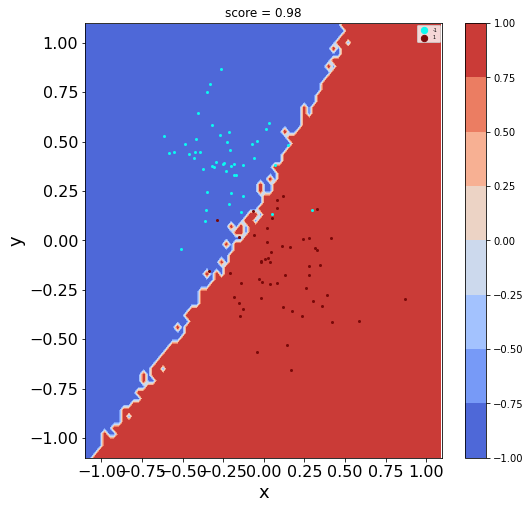

0.98

In [22]:
N_DRAW=1000000
q_fit(0, 1000)

>>> Resolve linear system


100%|██████████| 800/800 [05:18<00:00,  2.51it/s]


>>> Scoring


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]



>>>>>> quantum score =  0.91
>>> Plotting


100%|██████████| 74/74 [33:42<00:00, 27.33s/it]


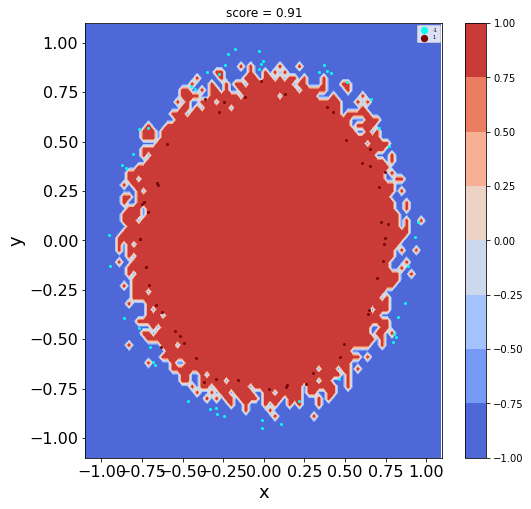

0.91

In [23]:
N_DRAW=1000000
q_fit(1, 1000)

#### Special case: lunar data set

>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 37.66it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 37.83it/s]



>>>>>> quantum score =  0.97
>>> Plotting


100%|██████████| 74/74 [02:18<00:00,  1.87s/it]


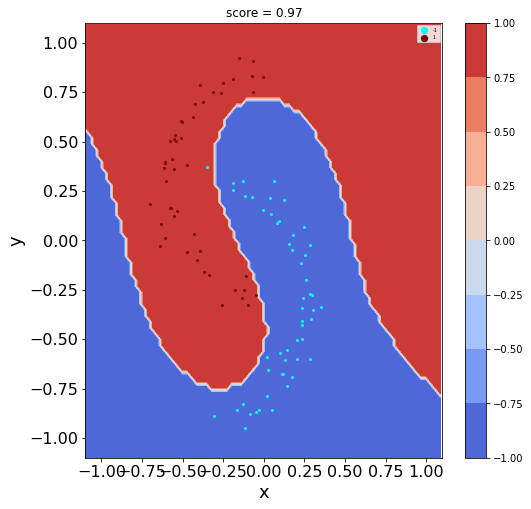

0.97

In [22]:
# ideal case
N_DRAW=float("inf")
step = 0
thermic_noise=0
q_fit(2, 1000)

>>> Resolve linear system


100%|██████████| 800/800 [07:08<00:00,  1.87it/s]


>>> Scoring


100%|██████████| 100/100 [00:52<00:00,  1.89it/s]



>>>>>> quantum score =  0.91
>>> Plotting


100%|██████████| 74/74 [48:56<00:00, 39.68s/it]


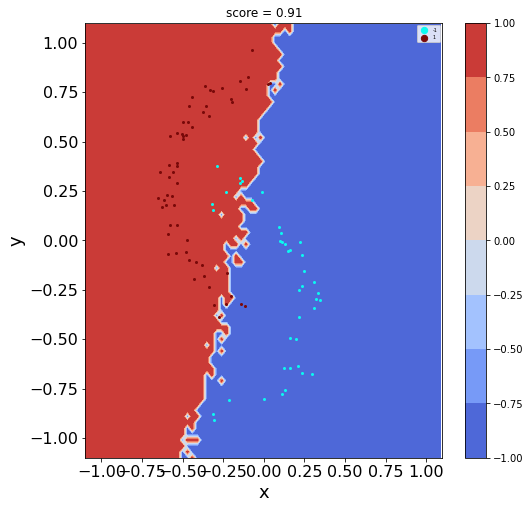

0.91

In [32]:
# noiseless case
N_DRAW=1000000
step = 0
thermic_noise=0
q_fit(2, 1000)

>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 36.90it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 37.72it/s]



>>>>>> quantum score =  0.88
>>> Plotting


100%|██████████| 74/74 [02:19<00:00,  1.88s/it]


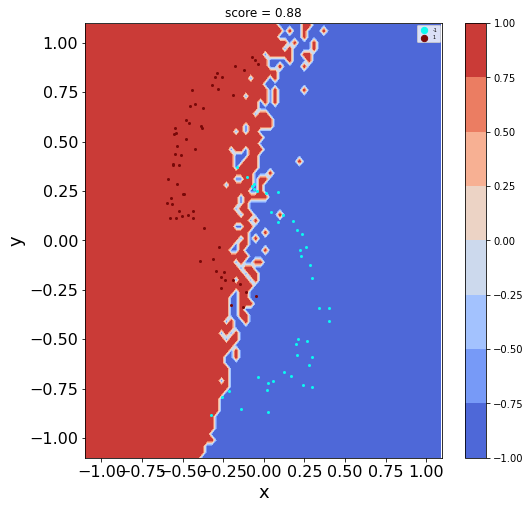

0.88

In [24]:
# no sampling
N_DRAW=float("inf")
step = 6.5 * 1e-3
thermic_noise=1e-3
q_fit(2, 1000)

>>> Resolve linear system


100%|██████████| 800/800 [09:48<00:00,  1.36it/s]


>>> Scoring


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]



>>>>>> quantum score =  0.85
>>> Plotting


100%|██████████| 74/74 [1:06:03<00:00, 53.56s/it]


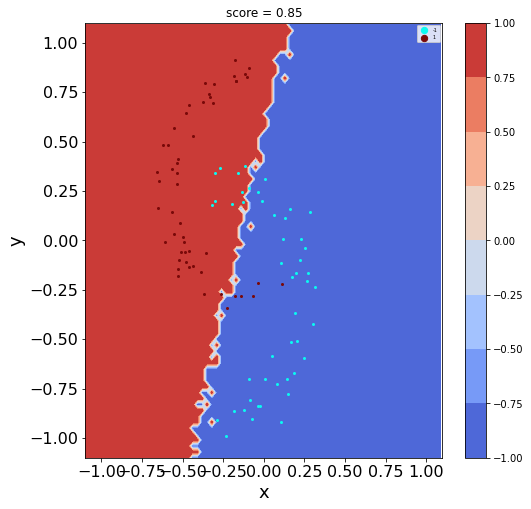

0.85

In [24]:
# all imperfections
step = 6.5 * 1e-3
thermic_noise=1e-3
N_DRAW=1000000
q_fit(2, 1000)

In order to assess the effect of noise, we plot the following graph.

>>> Resolve linear system


100%|██████████| 800/800 [00:22<00:00, 36.12it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 36.97it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 36.88it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 35.36it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:22<00:00, 35.53it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 37.23it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 37.41it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 39.02it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 37.29it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 34.22it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 37.44it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 37.02it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 36.99it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 35.32it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:22<00:00, 35.55it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 38.49it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:22<00:00, 36.20it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 35.28it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 37.06it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 36.90it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 36.99it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 37.66it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 37.73it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 36.12it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 37.93it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 36.11it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 36.84it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 37.22it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 36.76it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 34.43it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:22<00:00, 35.46it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 35.93it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:20<00:00, 38.27it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 39.77it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 38.03it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 40.52it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:20<00:00, 38.22it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 35.82it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:20<00:00, 38.24it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 36.58it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 36.99it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 36.83it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 36.97it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 36.15it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 36.75it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 38.38it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:20<00:00, 39.30it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 39.13it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:20<00:00, 38.22it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 36.45it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 36.50it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 36.28it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:22<00:00, 36.00it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 35.63it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:22<00:00, 35.59it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 36.93it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 36.99it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 36.84it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 37.45it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 37.98it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 36.82it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 36.82it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 36.80it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 36.43it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 37.15it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 40.51it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 36.71it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 35.95it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 37.38it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 38.75it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:20<00:00, 39.01it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 35.95it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 37.77it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 37.48it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 37.10it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 37.75it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:20<00:00, 38.35it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 33.78it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 36.73it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 35.62it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 36.54it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 36.40it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 37.41it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 35.59it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 36.84it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 35.72it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:22<00:00, 35.87it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 37.48it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:22<00:00, 36.00it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 38.86it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 36.78it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 38.35it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 36.68it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 36.53it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 36.98it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 37.67it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:22<00:00, 35.93it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 39.31it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:20<00:00, 38.64it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 36.41it/s]


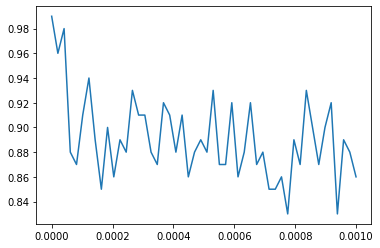

In [29]:
# thermic noise effect
N_DRAW=float("inf")
step=0
X = np.linspace(0,1e-3, num = 50)
plt.plot(X, [q_fit_short(x) for x in X])
plt.show()

We obtain the graph below:

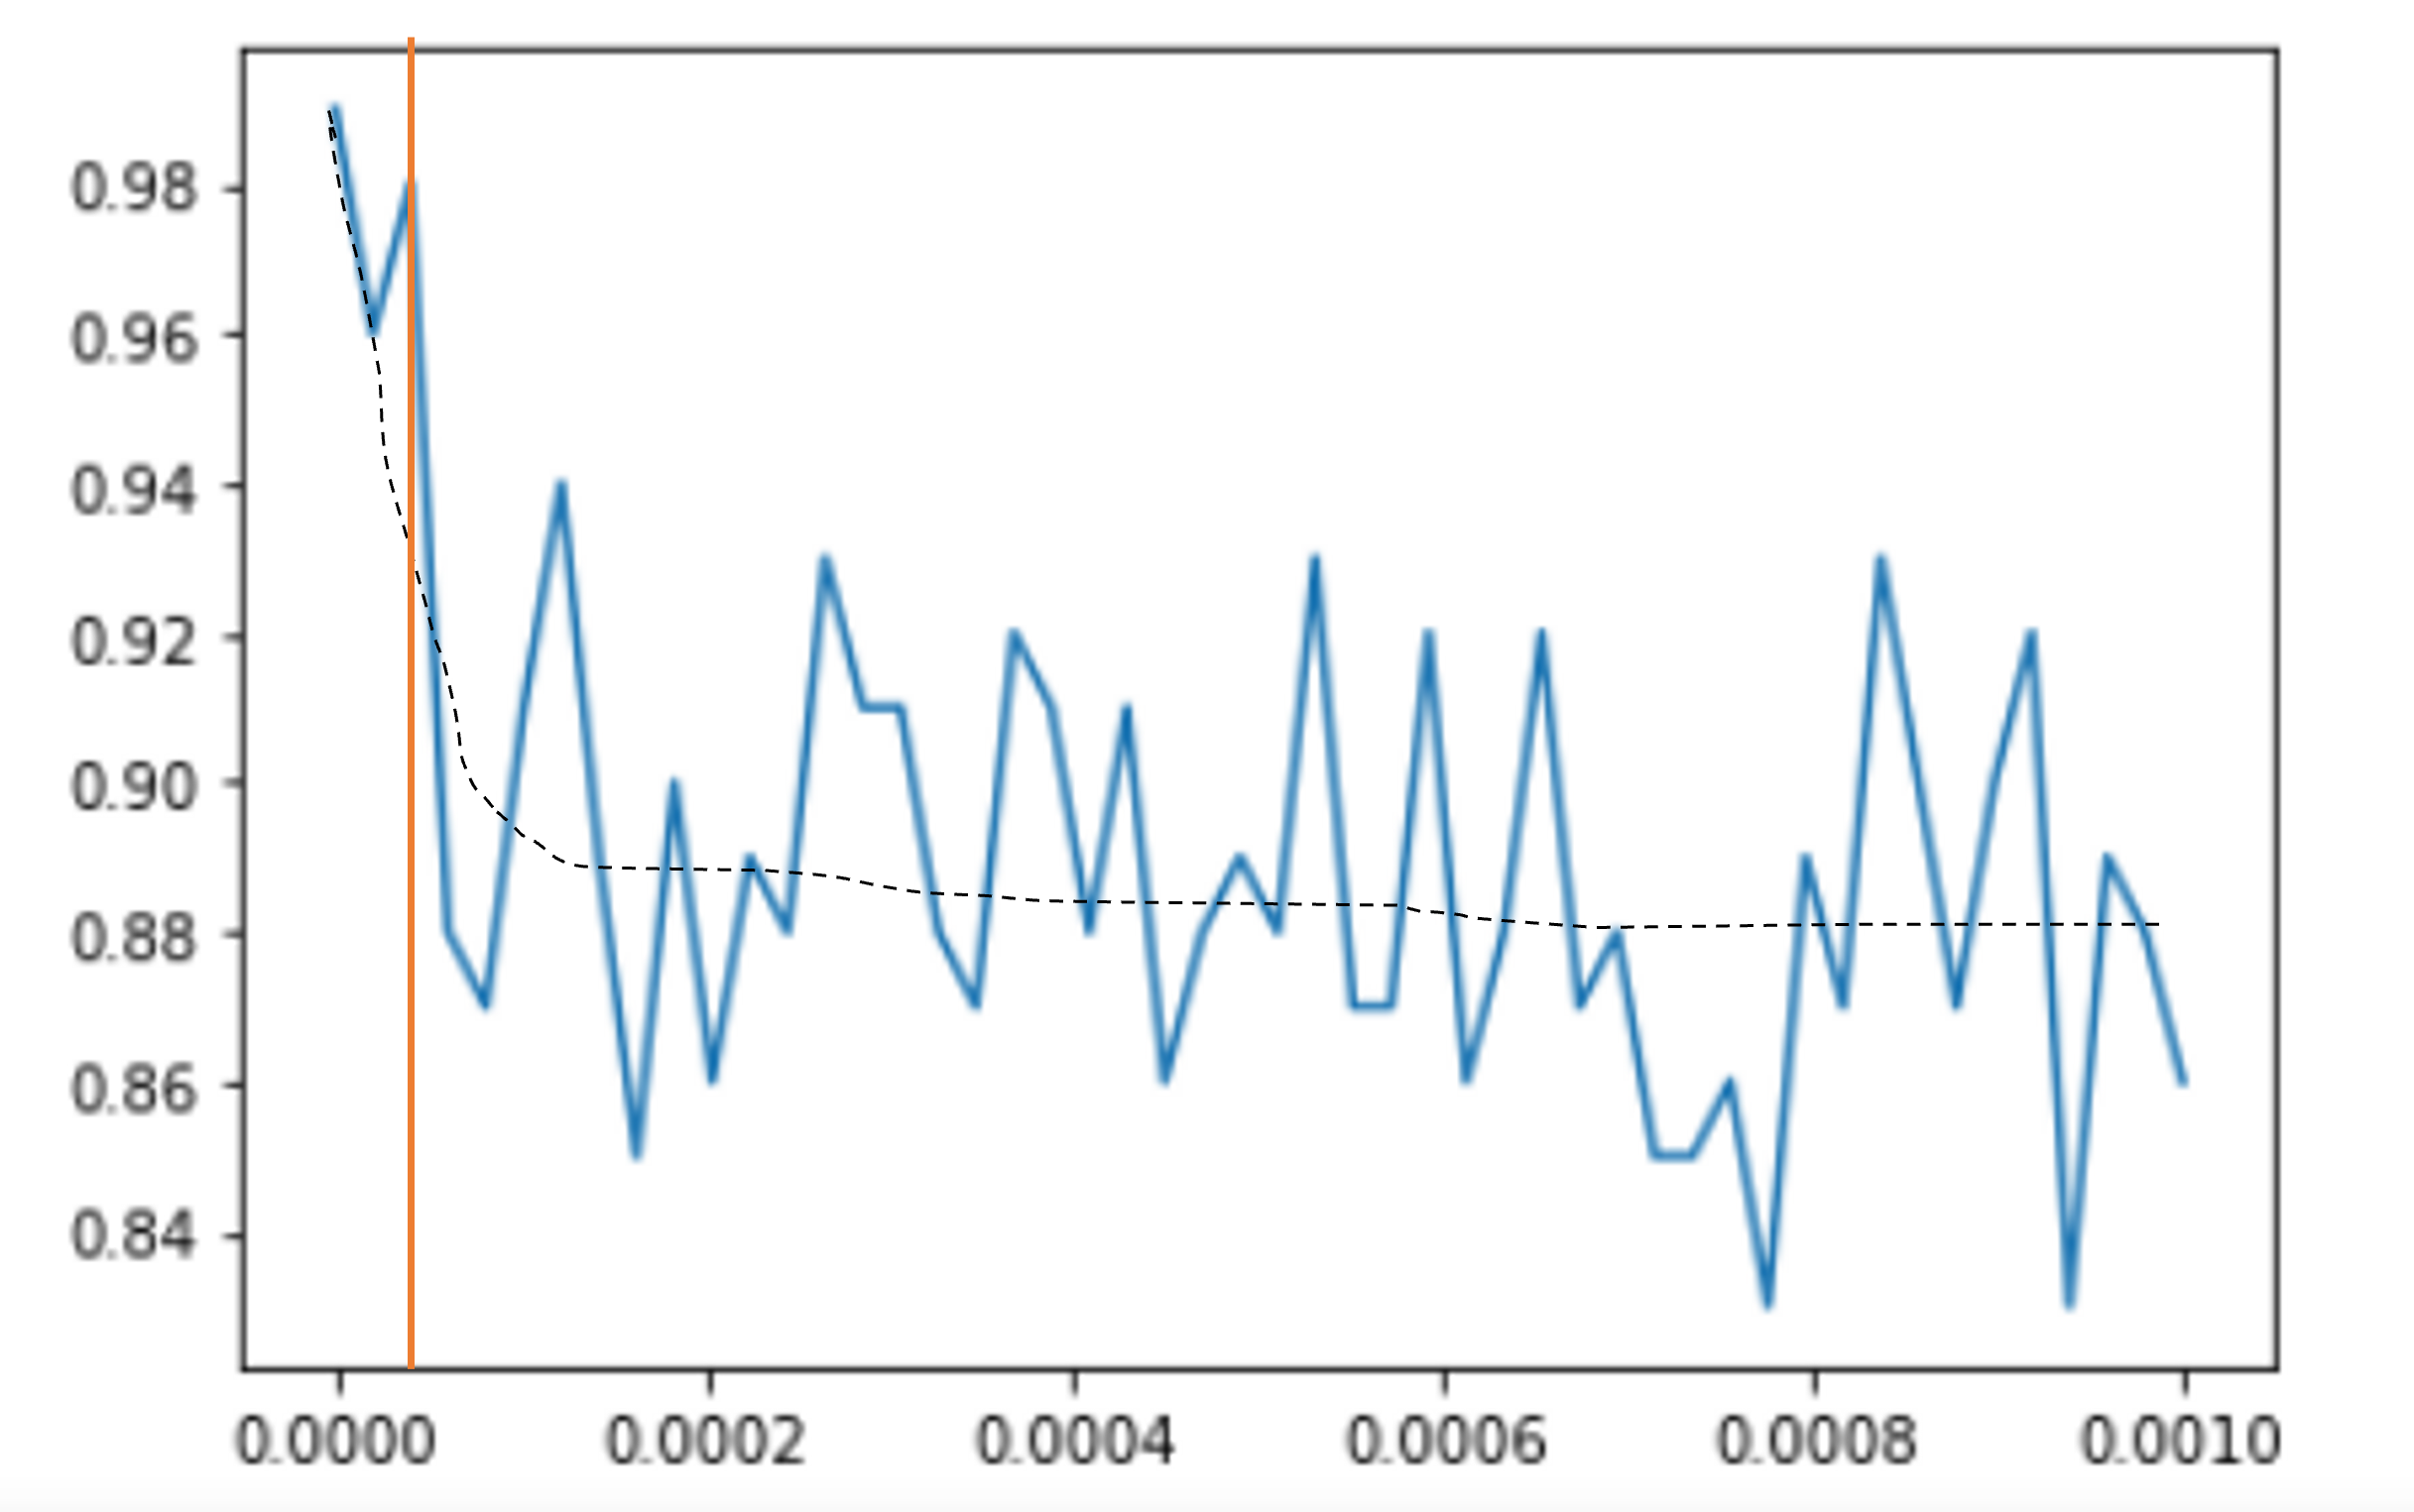

We can draw the following conclusions from the graph above:

1. The score decays exponentially with an asymptotic limit of roughly $0.88$.
2. The score  oscillates ($\pm 0.04$).
3. The critical noise is at $3 \times 10^{-5} \text{rad}$.

>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 36.97it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 40.03it/s]



>>>>>> quantum score =  1.0
>>> Plotting


100%|██████████| 74/74 [02:17<00:00,  1.86s/it]


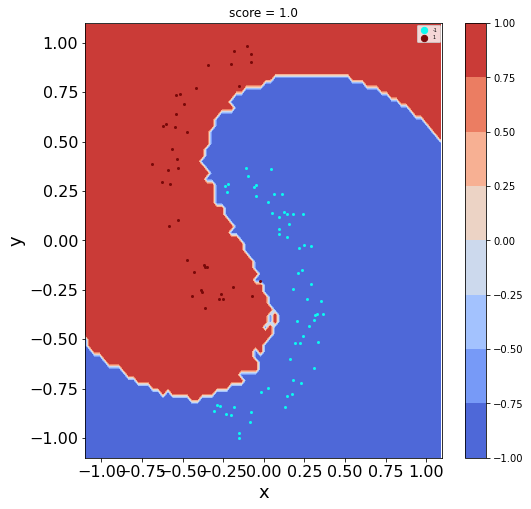

1.0

In [34]:
N_DRAW=float("inf")
step = 0
thermic_noise=5e-6
q_fit(2, 1000)

>>> Resolve linear system


100%|██████████| 800/800 [00:21<00:00, 37.05it/s]


>>> Scoring


100%|██████████| 100/100 [00:02<00:00, 36.70it/s]



>>>>>> quantum score =  0.94
>>> Plotting


100%|██████████| 74/74 [02:17<00:00,  1.86s/it]


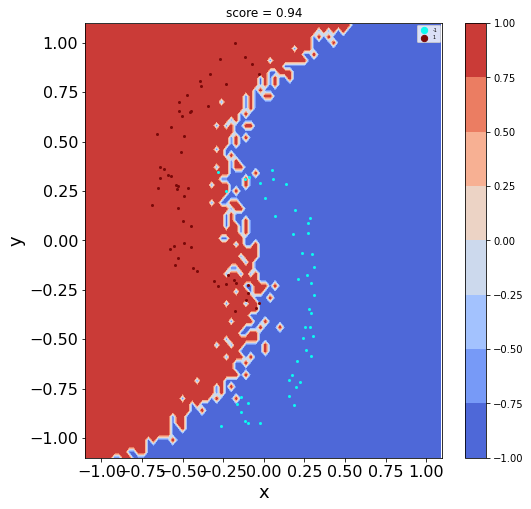

0.94

In [37]:
N_DRAW=float("inf")
step = 0
thermic_noise=6e-5
q_fit(2, 1000)